# 9.3 향후 판매량 예측 경진대회 베이스라인 모델
#### 베이스라인 모델 절차
- 모델로는 LightGBM 사용
<div>
    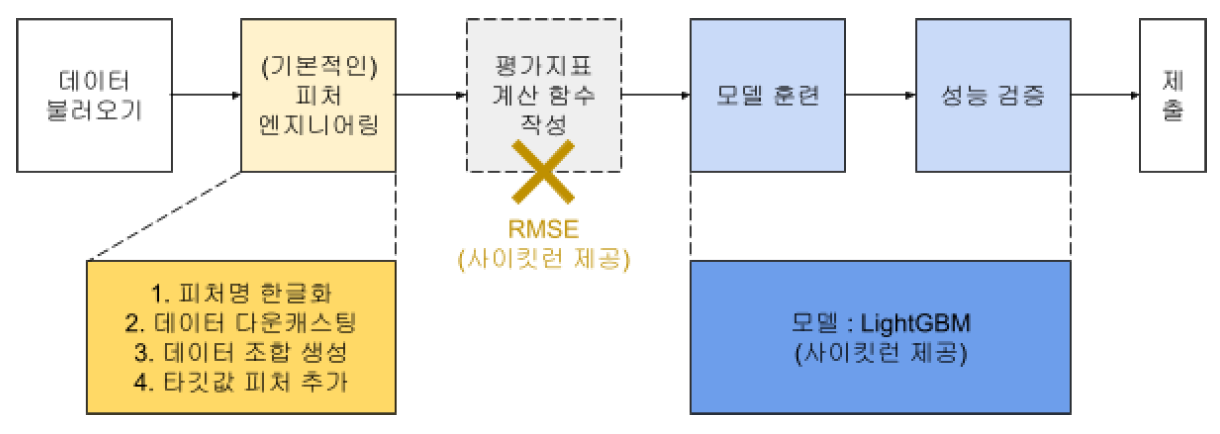
</div>

- 이번 장의 핵심은 피처 엔지니어링
 - 베이스라인에서는 간단하게만 할 계획이지만, 단계가 많아서 그림으로 먼저 보고 갑시다!
 
 <div>
    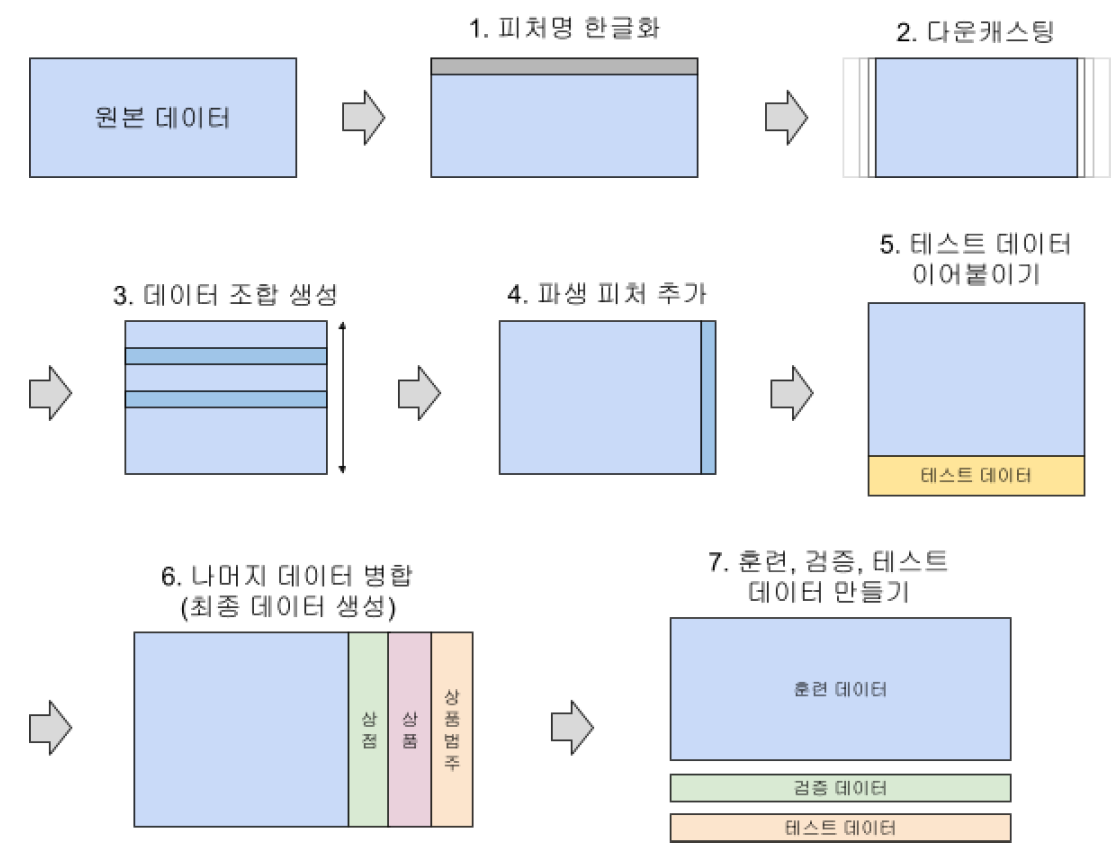
</div>

In [ ]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore') # 경고 문구 생략

# 데이터 경로
data_path = '/kaggle/input/competitive-data-science-predict-future-sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

## 9.3.1 피처 엔지니어링 I : 피처명 한글화

In [ ]:
sales_train = sales_train.rename(columns={'date': '날짜', 
                                          'date_block_num': '월ID',
                                          'shop_id': '상점ID',
                                          'item_id': '상품ID',
                                          'item_price': '판매가',
                                          'item_cnt_day': '판매량'})

sales_train.head()

In [ ]:
shops = shops.rename(columns={'shop_name': '상점명',
                              'shop_id': '상점ID'})

shops.head()

In [ ]:
items = items.rename(columns={'item_name': '상품명',
                              'item_id': '상품ID',
                              'item_category_id': '상품분류ID'})

items.head()

In [ ]:
item_categories = item_categories.rename(columns=
                                         {'item_category_name': '상품분류명',
                                          'item_category_id': '상품분류ID'})

item_categories.head()

In [ ]:
test = test.rename(columns={'shop_id': '상점ID',
                            'item_id': '상품ID'})

test.head()

## 9.3.2 피처 엔지니어링 II : 데이터 다운캐스팅 (p.628)

- #### **<font color='orange'> 메모리 관리 필요 </font>**
- 다운캐스팅(downcasting)이란 더 작은 데이터 타입으로 변환하는 작업
- 금붕어는 금붕어용 어항에서 키워야지, 돌고래용 수족관을 마련할 필요는 없다!
- 메모리 낭비를 막고, 훈련 속도를 빠르게 하려면 모든 데이터를 최대 타입으로 할당할 필요는 없음

- 다운캐스팅 적용

In [ ]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

## 9.3.3 피처 엔지니어링 III : 데이터 조합 생성
- 테스트 데이터 피처는 ID 피처를 제외하면 상점ID와 상품ID 피처임
- 우리가 예측해야 하는 값은 각 상점의 상품별 월간 판매량임
- 따라서 월, 상점, 상품별 조합이 필요

<div>
    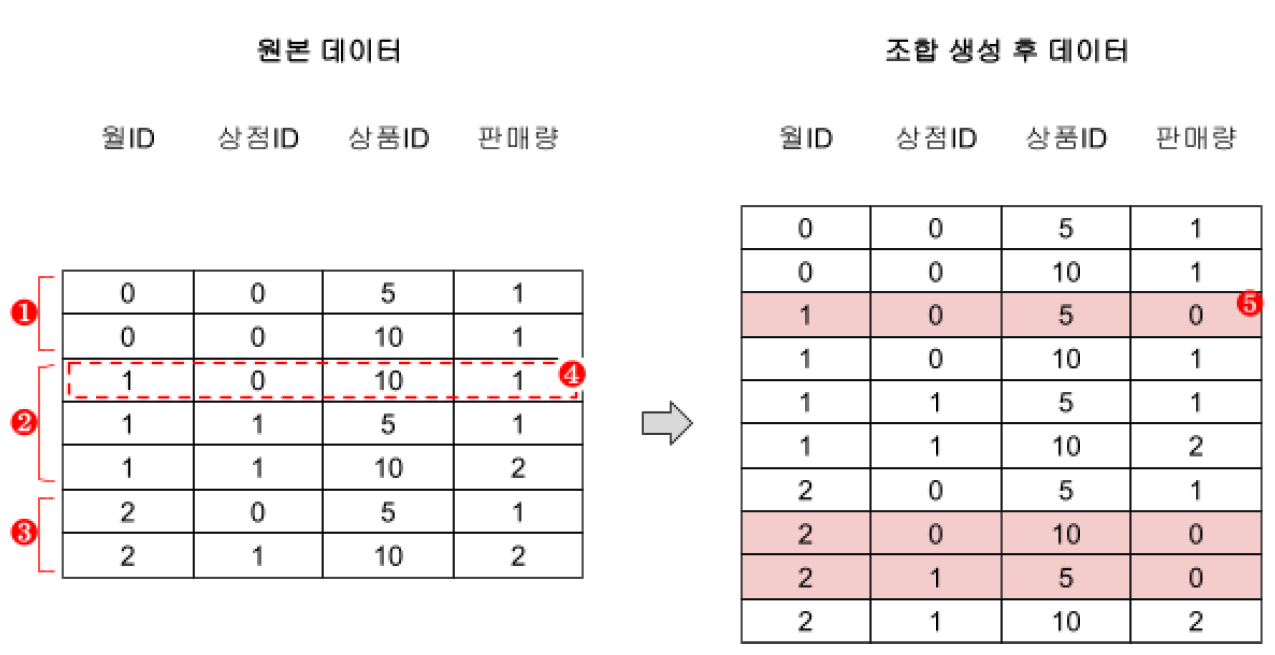
</div>

- 조합이란?
 - 원본 데이터의 월ID, 상점ID, 상품ID 피처가 왼쪽과 같다고 하자  
 - ① 월ID가 0일 때 상점ID는 0, 상품ID는 5와 10  
 - ② 월ID가 1일 때 상점ID는 0과 1, 상품ID는 5와 10  
 - ③ 월ID가 2일 때 상점ID는 0과 1, 상품ID는 5와 10  
 - 월ID별로 한 번이라도 등장한 상점ID, 상품ID가 있다면 그것들의 조합을 만듦(오른쪽 표와 같이)  
 - ④ 월ID가 1일 때 상점ID 0인 상점에서는 상품ID가 5인 상품을 팔지 못했기 때문에, 월ID=1, 상점ID=0, 상품ID=5인 데이터가 아예 없음  
 - ⑤ 아예 없는 것보단 판매량이 0이더라도 데이터가 있는 게 나음  

- itertools 패키지가 제공하는 product( ) 함수로 데이터 조합 생성

In [ ]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성 
for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID']==i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID']==i, '상품ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처
# 리스트 타입인 train을 DataFrame 타입으로 변환 
train = pd.DataFrame(np.vstack(train), columns=idx_features)

train

- 원래 sales_train 데이터 개수는 2,935,849개 → 조합 생성 후 10,913,850개로 3.7배 늘어남
- 이렇게 만든 train을 훈련 데이터 뼈대로 사용, 여기에 타깃값과 나머지 데이터(shops, items, item_categories) 병합 예정

## 9.3.4 피처 엔지니어링 IV : 타깃값(월간 판매량) 추가
- 타깃값인 각 상점의 상품별 월간 판매량 추가
 - sales_train에 있는 일별 판매량 피처를 그룹화해서 우리가 원하는 타깃값인 각 상점의 상품별 **‘월간’** 판매량 생성
 - #### **<font color='orange'> 타깃값 = date_block_num 피처의 값이 같은 데이터들의 item_cnt_day 값의 합</font>**
 - 앞서 피처 조합을 만들 때 생성한 idx_features = [‘월ID’, ‘상점ID’, ‘상품ID’]를 기준으로 그룹화

In [ ]:
idx_features

In [ ]:
# idx_features를 기준으로 그룹화해 판매량 합 구하기 
group = sales_train.groupby(idx_features).agg({'판매량': 'sum'})
# 인덱스 재설정
group = group.reset_index()
# 피처명을 '판매량'에서 '월간 판매량'으로 변경
group = group.rename(columns={'판매량': '월간 판매량'})

group

- ‘월간 판매량’을 구했으니 피처명 ‘판매량’도 ‘월간 판매량’으로 변경함

- train과 group을 병합
 - train은 월ID, 상점ID, 상품ID의 조합
 - train에 group을 병합하면 월ID, 상점ID, 상품ID, 월간 판매량 조합을 나타냄

In [ ]:
# train과 group 병합하기
train = train.merge(group, on=idx_features, how='left')

train

- 우리가 원하는 타깃값을 잘 만듦
 - 그런데 타깃값에 결측값이 많음 (결측값은 판매량 정보가 없다는 뜻이므로 추후 0으로 대체)
- 또한, train을 만드는 과정에서 sales_train에 있던 date(날짜) 피처가 사라짐
 #### **<font color='orange'>월별 판매량만 구하면 되니 date 피처 제거 : 필요 없는 date(날짜)피처를 명시적으로 제거한 게 아니라, 병합하는 과정에서 제외하여 같은 효과를 얻음</font>**

- 가비지 컬렉션
 - #### **<font color='orange'> 메모리 관리 필요 </font>**
 - group 데이터는 더 이상 필요 없으니 메모리 절약 차원에서 가비지 컬렉션(garbage collection) 수행 
  - 한정된 메모리를 효율적으로 사용하려면 틈틈이 가비지 컬렉션해주는 게 좋음

In [ ]:
import gc # 가비지 컬렉터 불러오기

del group # 더는 사용하지 않는 변수 지정
gc.collect(); # 가비지 컬렉션 수행

## 9.3.5 피처 엔지니어링 V : 테스트 데이터 이어붙이기
- 지금까지 한 작업 되돌아보기
 - 월ID, 상점ID, 상품ID 조합으로 train을 만들고, 여기에 월간 판매량(타깃값)을 추가함

- 테스트 데이터 이어붙이기
 - 뒤이어 shops, items, item_categories 데이터를 병합할 텐데, 이때 테스트 데이터에도 한 번에 병합하는 게 좋기 때문
 - 우선, 테스트 데이터의 월ID 피처 추가 (2015년 10월의 월ID가 33이므로 2015년 11월의 월ID는 34)

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
test['월ID'] = 34

- 식별자인 ‘ID’ 피처를 제거한 test를 이어붙임

In [ ]:
# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True, # 기존 인덱스 무시(0부터 새로 시작)
                     keys=idx_features) # 이어붙이는 기준이 되는 피처

In [ ]:
all_data

- train과 group을 병합할 때 결측값이 많았기 때문에 결측값은 0으로 대체

In [ ]:
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data

## 9.3.6 피처 엔지니어링 VI : 나머지 데이터 병합(최종 데이터 생성)

- #### **<font color='orange'> shop_id를 기준으로 sales_train과 shops 병합 </font>**
- #### **<font color='orange'> item_id를 기준으로 sales_train과 items 병합 </font>**
- #### **<font color='orange'> item_category_id를 기준으로 sales_train과 item_categories 병합 </font>**
- 즉, 나머지 데이터를 all_data에 병합

- 추가로, 메모리 관리를 위해 데이터 다운캐스팅과 가비지 컬렉션 수행 

In [ ]:
# 나머지 데이터 병합
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')

# 데이터 다운캐스팅
all_data = downcast(all_data)

# 가비지 컬렉션
del shops, items, item_categories
gc.collect();

- 병합한 데이터 확인

In [ ]:
all_data.head()

- 상점명, 상품명, 상품분류명 피처 제거
 - #### **<font color='orange'>문자 데이터이기도 하거니와, 상점ID, 상품ID, 상품분류ID와 각각 상점명, 상품명, 상품분류명이 1:1 매칭되므로 제거 </font>**

In [ ]:
all_data = all_data.drop(['상점명', '상품명', '상품분류명'], axis=1)

## 9.3.7 피처 엔지니어링 VII : 마무리
- 훈련, 검증, 테스트 데이터로 나누기
 - 훈련 데이터 : 2013년 1월~2015년 9월(월ID=32)
 - 검증 데이터 : 2015년 10월(월ID=33) (**<font color='orange'> 훈련 데이터 중 가장 최근인 2015년 10월 판매 내역을 검증 데이터로 사용</font>**)
 - 테스트 데이터 : 2015년 11월(월ID=34)
 - clip( ) 함수를 활용해 월간 판매량을 0~20 사이로 제한 

In [ ]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['월ID'] < 33]
X_train = X_train.drop(['월간 판매량'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['월ID'] < 33]['월간 판매량']
y_train = y_train.clip(0, 20) # 타깃값을 0 ~ 20로 제한
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['월ID'] == 33]['월간 판매량']
y_valid = y_valid.clip(0, 20)

In [ ]:
del all_data
gc.collect();

## 9.3.8 모델 훈련 및 성능 검증 (p.157)
- LightGBM을 활용해 베이스라인 모델 훈련
 - 범주형 데이터인 상점ID, 상품ID, 상품분류ID 중 고윳값 개수가 너무 많은 상품ID는 범주형 데이터로 취급하지 않음 (LightGBM 문서에 따르면, 고윳값 개수가 너무 많은 범주형 데이터는 수치형 데이터로 취급해야 성능이 더 잘 나옴)

In [ ]:
import lightgbm as lgb

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse', # 평가지표 = rmse
          'num_leaves': 255,
          'learning_rate': 0.01,
          'force_col_wise': True,
          'random_state': 10}

# 범주형 피처 설정
cat_features = ['상점ID', '상품분류ID']

# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)

# LightGBM 모델 훈련
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=500,
                      valid_sets=(dtrain, dvalid),
                      categorical_feature=cat_features,
                      verbose_eval=50)  

## 9.3.9 예측 및 결과 제출

In [ ]:
# 예측
preds = lgb_model.predict(X_test).clip(0, 20)
# 제출 파일 생성
submission['item_cnt_month'] = preds
submission.to_csv('submission.csv', index=False)

- 끝으로 가비지 컬렉션 수행

In [ ]:
del X_train, y_train, X_valid, y_valid, X_test, lgb_model, dtrain, dvalid
gc.collect();

- 퍼블릭 점수: 1.08159